In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import models
import flows

In [2]:
data = sio.loadmat("./data/downstream.mat")
f_ref = data["f"]
u_ref = data["sol"]
xx = data["xx"]
yy = data["yy"]
lamb = data["lamb"]

#### It works as expected. Now let's downsample it.

In [3]:
# x_train = xx[1::2, 1::2].reshape([-1, 1])
# y_train = yy[1::2, 1::2].reshape([-1, 1])
# f_train = f_ref[1::2, 1::2].reshape([-1, 1])

# idx = np.random.choice(x_train.shape[0], x_train.shape[0], replace=False)[:100]
# x_train = x_train[idx]
# y_train = y_train[idx]
# f_train = f_train[idx]

# sio.savemat(
#     "downtream_train.mat",
#     {
#         "x_train": x_train, 
#         "y_train": y_train,
#         "f_train": f_train,
#         "xx": xx, "yy": yy,
#         "u_ref": u_ref, "f_ref": f_ref,
#     }
# )

data = sio.loadmat("downtream_train.mat")
x_train = data["x_train"]
y_train = data["y_train"]
f_train = data["f_train"]
xx = data["xx"]
yy = data["yy"]
u_ref = data["u_ref"]
f_ref = data["f_ref"]

In [4]:
model = models.PINN(units=200, name="test", eps=1e-6)

In [5]:
loss = model.train(x_train, y_train, f_train, niter=50000)

0 0.30952004
1000 0.007287591
2000 0.005823394
3000 0.008689211
4000 0.0024694426
5000 0.0021097418
6000 0.0018709956
7000 0.0011956558
8000 0.0007236876
9000 0.0006252309
10000 0.0009762548
11000 0.00048657475
12000 0.000463173
13000 0.0007209233
14000 0.00032547463
15000 0.000313481
16000 0.00030340164
17000 0.0002527978
18000 0.00024741553
19000 0.00021430086
20000 0.0002107188
21000 0.00018758327
22000 0.0008481302
23000 0.00017237439
24000 0.0012733508
25000 0.00016858579
26000 0.0001717114
27000 0.00014609176
28000 0.00030437042
29000 0.00013564689
30000 0.00014228953
31000 0.0001578024
32000 0.00010995525
33000 0.00016225068
34000 0.000109165834
35000 0.000105669795
36000 0.00010867302
37000 0.00010638077
38000 9.6843105e-05
39000 9.502587e-05
40000 9.196017e-05
41000 9.1659036e-05
42000 8.462215e-05
43000 9.4733165e-05
44000 8.056691e-05
45000 9.485822e-05
46000 9.5560456e-05
47000 7.833127e-05
48000 7.750311e-05
49000 7.672911e-05


1.8949213784616914


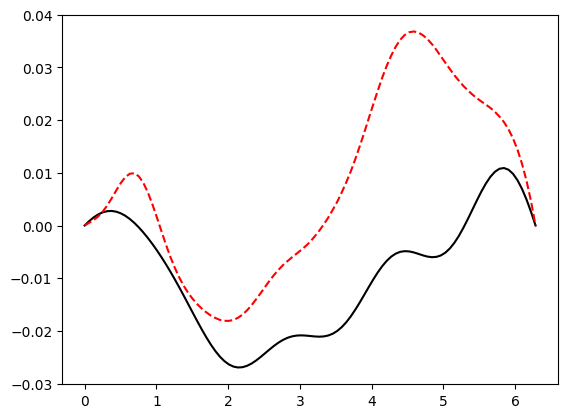

In [15]:
model.restore()
xx_test = tf.constant(xx.reshape([-1, 1]), tf.float32)
yy_test = tf.constant(yy.reshape([-1, 1]), tf.float32)
u_pred = model.call(xx_test, yy_test).numpy()
u_pred = u_pred.reshape([101, 101])
f_pred = model.pde(xx_test, yy_test).numpy()
f_pred = f_pred.reshape([101, 101])
print(np.linalg.norm(u_pred - u_ref, "fro") / np.linalg.norm(u_ref, "fro"))
j = 50
plt.plot(np.linspace(0, 2*np.pi, 101), u_ref[j, :], "k-")
plt.plot(np.linspace(0, 2*np.pi, 101), u_pred[j, :], "r--")

plt.show()

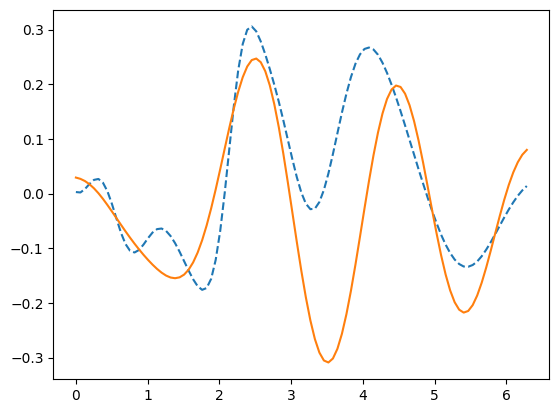

In [16]:
j = 25
plt.plot(np.linspace(0, 2*np.pi, 101), f_pred[j, :], "--")
plt.plot(np.linspace(0, 2*np.pi, 101), f_ref[j, :])
plt.show()

In [17]:
sio.savemat(
    "pinn.mat",
    {
        "xx": xx, "yy": yy,
        "u_pred": u_pred, "f_pred": f_pred,
        "u_ref": u_ref, "f_ref": f_ref,
        "x_train": x_train, "y_train": y_train,
        "f_train": f_train
    }
)

#### Fine-tuning with gradient descent

In [9]:
# load models
mhpinn = models.MHPINN(
    num_tasks=10000, dim=200, name="mhpinn6",
)
mhpinn.restore()
permutation = list(np.arange(101, 201, 1)) + list(np.arange(0, 101, 1))
nf = flows.MAF(
    dim=201,
    permutation=permutation,
    hidden_layers=[100, 100],
    num_bijectors=10,
    activation=tf.nn.relu,
    name="maf",
)
nf.restore()

In [10]:
new_model = models.Downstream(
    mhnn=mhpinn, flow=nf, dim=200, eps=1e-6,
)

In [11]:
loss = new_model.train(
    x_train, y_train, f_train, niter=20000
)

0 0.02747456 , time:  4.161440372467041
1000 0.00015928774 , time:  8.772191762924194
2000 -0.0004571344 , time:  7.628719091415405
3000 -0.0006495262 , time:  8.321855068206787
4000 -0.0006982107 , time:  12.468640565872192
5000 -0.0007153096 , time:  13.856393337249756
6000 -0.00072560855 , time:  14.641554594039917
7000 -0.0007262697 , time:  13.688161134719849
8000 -0.0007367039 , time:  13.78928279876709
9000 -0.0006840362 , time:  14.117393732070923
10000 -0.0007441615 , time:  14.162672996520996
11000 -0.0007454123 , time:  13.74105453491211
12000 -0.00074841536 , time:  13.641456127166748
13000 -0.00074981997 , time:  14.031005620956421
14000 -0.00075048296 , time:  13.648803472518921
15000 -0.00072993647 , time:  13.693240642547607
16000 -0.0007520675 , time:  14.146591186523438
17000 -0.00075199304 , time:  14.244209051132202
18000 -0.0007538276 , time:  14.581809043884277
19000 -0.000753374 , time:  13.963618755340576


0.025548127896591034


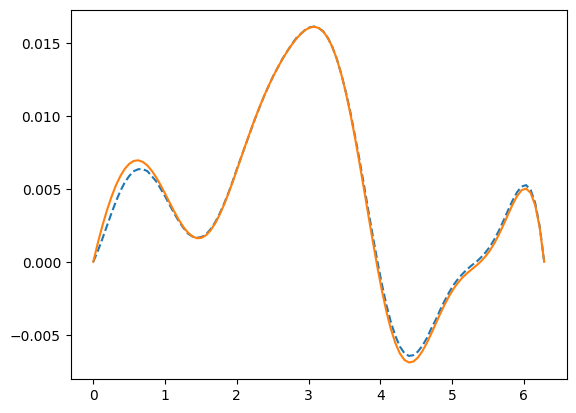

In [12]:
new_model.restore()
xx_test = tf.constant(xx.reshape([-1, 1]), tf.float32)
yy_test = tf.constant(yy.reshape([-1, 1]), tf.float32)
u_pred = new_model.call(xx_test, yy_test).numpy()
u_pred = u_pred.reshape([101, 101])
f_pred = new_model.pde(xx_test, yy_test).numpy()
f_pred = f_pred.reshape([101, 101])
print(np.linalg.norm(u_pred - u_ref, "fro") / np.linalg.norm(u_ref, "fro"))
j = 90
plt.plot(np.linspace(0, 2*np.pi, 101), u_pred[j, :], "--")
plt.plot(np.linspace(0, 2*np.pi, 101), u_ref[j, :])
plt.show()

0.08008202234790925


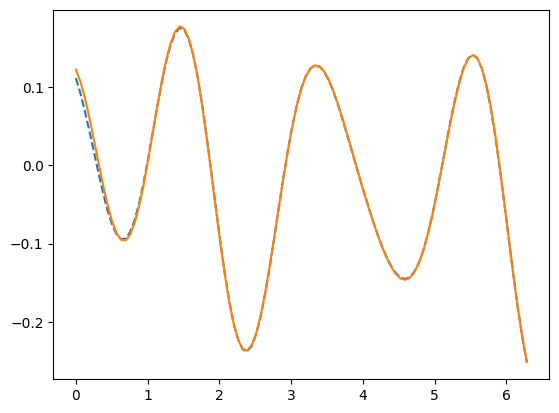

In [13]:
print(np.linalg.norm(f_pred - f_ref, "fro") / np.linalg.norm(f_ref, "fro"))
j = 10
plt.plot(np.linspace(0, 2*np.pi, 101), f_pred[j, :], "--")
plt.plot(np.linspace(0, 2*np.pi, 101), f_ref[j, :])
plt.show()

In [14]:
sio.savemat(
    "gd.mat",
    {
        "xx": xx, "yy": yy,
        "u_pred": u_pred, "f_pred": f_pred,
        "u_ref": u_ref, "f_ref": f_ref,
        "x_train": x_train, "y_train": y_train,
        "f_train": f_train
    }
)